# Analyse du discours des Banques Centrales

In [1]:
import datetime
import copy as c
import random
import collections
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
#!pip install spacy
#!pip install spacy-langdetect
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
#!python -m spacy download en_core_web_lg 

In [2]:
url="https://www.ecb.europa.eu/press/key/shared/data/all_ECB_speeches.csv?848ea64ce6d77827b5e8e18790878b64"
#df=pd.read_csv(url,sep = "|",encoding='utf-8')

# Une connexion lente peut obliger à télécharger le fichier en local
url_local=r"C:\Users\Antoine\Downloads\all_ECB_speeches.csv"
df=pd.read_csv(url_local,sep = "|",encoding='utf-8')

# fichier mis à jour tous les mois, dernière version : 1er décembre 2021 (47,8 Mo)
# à récupérer à l'adresse : https://www.ecb.europa.eu/press/key/html/downloads.en.html
# 2549 discours de responsables de la BCE entre 1997 et 2021

In [3]:
df

date              speakers  \
0     2021-11-29     Christine Lagarde   
1     2021-11-29       Isabel Schnabel   
2     2021-11-26     Christine Lagarde   
3     2021-11-25        Frank Elderson   
4     2021-11-25       Isabel Schnabel   
...          ...                   ...   
2544  1997-05-13  Alexandre Lamfalussy   
2545  1997-04-30  Alexandre Lamfalussy   
2546  1997-04-22  Alexandre Lamfalussy   
2547  1997-03-10  Alexandre Lamfalussy   
2548  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0                          Dialogue in a changing world   
1          Inflation im Euroraum: Ursachen und Ausblick   
2                          Change and continuity in law   
3     When you need change to preserve continuity: c...   
4          Inflation im Euroraum: Ursachen und Ausblick   
...                                                 ...   
2544  The European Central Bank: independent and acc...   
2545  The operation of monetary policy in stage thre...   
2546  Convergence and the role of the European Centr...   
2547                       Securing the benefits of EMU   
2548  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lectio Magistralis by Christine Lagarde, Presi...   
1     Presentation by Isabel Schnabel, Member of the...   
2     Keynote speech by Christine Lagarde, President...   
3     Speech by Frank Elderson, Member of the Execut...   
4     Presentation by Isabel Schnabel, Member of the...   
...                                                 ...   
2544  Keynote speech delivered by Alexandre Lamfalus...   
2545  Address by Alexandre Lamfalussy, President of ...   
2546  Remarks by Alexandre Lamfalussy, President of ...   
2547  Address by Alexandre Lamfalussy, President of ...   
2548  Address by Alexandre Lamfalussy, President of ...   

                                               contents  
0        SPEECH  Dialogue in a changing world   Lect...  
1                                                   NaN  
2        SPEECH  Change and continuity in law   Keyn...  
3        SPEECH  When you need change to preserve co...  
4                                                   NaN  
...                                                 ...  
2544    The European Central Bank: independent and a...  
2545    The operation of monetary policy in stage th...  
2546    Convergence and the role of the European Cen...  
2547    Securing the benefits of EMU   Address by Al...  
2548    Conference organised by the Hungarian Bankin...  

[2549 rows x 5 columns]

In [4]:
print(df.isna().sum())
# on affiche un dataframe avec toutes les lignes contenant au moins un NaN
df[df.isna().any(axis=1)] 

date         0
speakers     1
title        0
subtitle     1
contents    39
dtype: int64


date                  speakers  \
1     2021-11-29           Isabel Schnabel   
4     2021-11-25           Isabel Schnabel   
5     2021-11-24           Isabel Schnabel   
14    2021-11-11            Philip R. Lane   
17    2021-11-09             Fabio Panetta   
31    2021-10-07            Philip R. Lane   
41    2021-09-15            Philip R. Lane   
44    2021-08-26           Isabel Schnabel   
52    2021-06-24           Isabel Schnabel   
53    2021-06-22           Isabel Schnabel   
54    2021-06-22            Philip R. Lane   
63    2021-05-25            Philip R. Lane   
66    2021-05-05            Philip R. Lane   
70    2021-04-14           Isabel Schnabel   
76    2021-03-18                       NaN   
85    2021-02-25           Luis de Guindos   
88    2021-02-18           Isabel Schnabel   
96    2020-12-17           Isabel Schnabel   
99    2020-12-15            Philip R. Lane   
104   2020-11-24            Philip R. Lane   
113   2020-11-05           Isabel Schnabel   
120   2020-10-21            Philip R. Lane   
124   2020-10-14            Philip R. Lane   
129   2020-10-01            Philip R. Lane   
148   2020-07-02           Isabel Schnabel   
153   2020-06-25           Isabel Schnabel   
155   2020-06-22            Philip R. Lane   
184   2020-02-05            Philip R. Lane   
188   2020-01-09           Isabel Schnabel   
189   2020-01-09            Philip R. Lane   
208   2019-11-15            Philip R. Lane   
220   2019-10-16            Philip R. Lane   
237   2019-09-04            Philip R. Lane   
249   2019-06-24     Sabine Lautenschläger   
288   2019-02-20               Peter Praet   
346   2018-09-17               Peter Praet   
353   2018-08-28               Peter Praet   
364   2018-06-15              Benoît Cœuré   
1723  2007-08-29  Gertrude Tumpel-Gugerell   

                                                  title  \
1          Inflation im Euroraum: Ursachen und Ausblick   
4          Inflation im Euroraum: Ursachen und Ausblick   
5                   A new strategy for a changing world   
14    Expectations surveys: a tool for research and ...   
17    Digital currencies around the world – what are...   
31    Data analysis and monetary policy during the p...   
41    The ECB's monetary policy strategy review - IM...   
44    Die neue geldpolitische Strategie der Europäis...   
52    The ECB’s policy response to the COVID-19 pand...   
53          Die Geldpolitik der EZB in der Corona-Krise   
54                           The resilience of the euro   
63                              The ECB strategy review   
66    Taking stock: The ECB strategy review and curr...   
70          Die Geldpolitik der EZB in der Corona-Krise   
76          Die Geldpolitik der EZB in der Corona-Krise   
85    Sources of risk and vulnerabilities for financ...   
88    The ECB's policy response to the COVID-19 pand...   
96                   Climate change and monetary policy   
99                           The resilience of the euro   
104   IMF Policy dialogue: New policy frameworks for...   
113   Unequal scars – distributional consequences of...   
120   International flows and the pandemic: evidence...   
124                The pandemic and ECB monetary policy   
129   The euro area: a laboratory for international ...   
148   The ECB’s monetary policy during the coronavir...   
153    The ECB's policy response to the COVID-19 crisis   
155   Understanding the pandemic emergency purchase ...   
184                              The future of the euro   
188     Mehr Europa für eine stabile gemeinsame Währung   
189   Policy Frameworks and Strategies for an Open E...   
208          Europe’s role in a changing global economy   
220              The economic outlook for the euro area   
237                       The Phillips Curve at the ECB   
249   Die EZB, das Geld und die Wirtschaft: Von A wi...   
288                      Economic situation and outlook   
346              Economic developments in the e

On remarque que pour tous les discours, on a seulement le titre et le speaker mais le contenu est NaN. Il faut donc mettre de côté tous ces discours sans contenu. Ce cas se présente seulement pour 39 discours (soit 1,5% de la base de données).

In [5]:
df=df.dropna(axis='index',how='any')
df=df.reset_index(drop=True)

In [6]:
df

date              speakers  \
0     2021-11-29     Christine Lagarde   
1     2021-11-26     Christine Lagarde   
2     2021-11-25        Frank Elderson   
3     2021-11-24         Fabio Panetta   
4     2021-11-22       Luis de Guindos   
...          ...                   ...   
2505  1997-05-13  Alexandre Lamfalussy   
2506  1997-04-30  Alexandre Lamfalussy   
2507  1997-04-22  Alexandre Lamfalussy   
2508  1997-03-10  Alexandre Lamfalussy   
2509  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0                          Dialogue in a changing world   
1                          Change and continuity in law   
2     When you need change to preserve continuity: c...   
3         Patient monetary policy amid a rocky recovery   
4     Ralph Koijen’s contribution to research on the...   
...                                                 ...   
2505  The European Central Bank: independent and acc...   
2506  The operation of monetary policy in stage thre...   
2507  Convergence and the role of the European Centr...   
2508                       Securing the benefits of EMU   
2509  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lectio Magistralis by Christine Lagarde, Presi...   
1     Keynote speech by Christine Lagarde, President...   
2     Speech by Frank Elderson, Member of the Execut...   
3     Speech by Fabio Panetta, Member of the Executi...   
4     Remarks by Luis de Guindos, Vice-President of ...   
...                                                 ...   
2505  Keynote speech delivered by Alexandre Lamfalus...   
2506  Address by Alexandre Lamfalussy, President of ...   
2507  Remarks by Alexandre Lamfalussy, President of ...   
2508  Address by Alexandre Lamfalussy, President of ...   
2509  Address by Alexandre Lamfalussy, President of ...   

                                               contents  
0        SPEECH  Dialogue in a changing world   Lect...  
1        SPEECH  Change and continuity in law   Keyn...  
2        SPEECH  When you need change to preserve co...  
3        SPEECH  Patient monetary policy amid a rock...  
4        SPEECH  Ralph Koijen’s contribution to rese...  
...                                                 ...  
2505    The European Central Bank: independent and a...  
2506    The operation of monetary policy in stage th...  
2507    Convergence and the role of the European Cen...  
2508    Securing the benefits of EMU   Address by Al...  
2509    Conference organised by the Hungarian Bankin...  

[2510 rows x 5 columns]

### En explorant le dataset, on se rend compte que certains contenus de discours sont vides (empty string mais pas NaN).
### Il faut donc retirer ces lignes du dataframe.

In [7]:
L=[]
for i in range(len(df)):
    if not bool(df["contents"][i].strip()): #si le contenu du discours est vide
        L.append(i)
L # ne concerne qu'une ligne

[2009]

In [8]:
df=df.drop(L).reset_index(drop=True)
df

date              speakers  \
0     2021-11-29     Christine Lagarde   
1     2021-11-26     Christine Lagarde   
2     2021-11-25        Frank Elderson   
3     2021-11-24         Fabio Panetta   
4     2021-11-22       Luis de Guindos   
...          ...                   ...   
2504  1997-05-13  Alexandre Lamfalussy   
2505  1997-04-30  Alexandre Lamfalussy   
2506  1997-04-22  Alexandre Lamfalussy   
2507  1997-03-10  Alexandre Lamfalussy   
2508  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0                          Dialogue in a changing world   
1                          Change and continuity in law   
2     When you need change to preserve continuity: c...   
3         Patient monetary policy amid a rocky recovery   
4     Ralph Koijen’s contribution to research on the...   
...                                                 ...   
2504  The European Central Bank: independent and acc...   
2505  The operation of monetary policy in stage thre...   
2506  Convergence and the role of the European Centr...   
2507                       Securing the benefits of EMU   
2508  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lectio Magistralis by Christine Lagarde, Presi...   
1     Keynote speech by Christine Lagarde, President...   
2     Speech by Frank Elderson, Member of the Execut...   
3     Speech by Fabio Panetta, Member of the Executi...   
4     Remarks by Luis de Guindos, Vice-President of ...   
...                                                 ...   
2504  Keynote speech delivered by Alexandre Lamfalus...   
2505  Address by Alexandre Lamfalussy, President of ...   
2506  Remarks by Alexandre Lamfalussy, President of ...   
2507  Address by Alexandre Lamfalussy, President of ...   
2508  Address by Alexandre Lamfalussy, President of ...   

                                               contents  
0        SPEECH  Dialogue in a changing world   Lect...  
1        SPEECH  Change and continuity in law   Keyn...  
2        SPEECH  When you need change to preserve co...  
3        SPEECH  Patient monetary policy amid a rock...  
4        SPEECH  Ralph Koijen’s contribution to rese...  
...                                                 ...  
2504    The European Central Bank: independent and a...  
2505    The operation of monetary policy in stage th...  
2506    Convergence and the role of the European Cen...  
2507    Securing the benefits of EMU   Address by Al...  
2508    Conference organised by the Hungarian Bankin...  

[2509 rows x 5 columns]

#### On se rend compte que certains discours ne sont pas en anglais.
#### Il faut donc les retirer.

Nombre moyen de caractères dans les discours :  19632.969310482265
Minimum de caractères dans les discours :  249
Maximum de caractères dans les discours :  113165


<AxesSubplot:title={'center':'Nombre de caractères dans les discours'}>

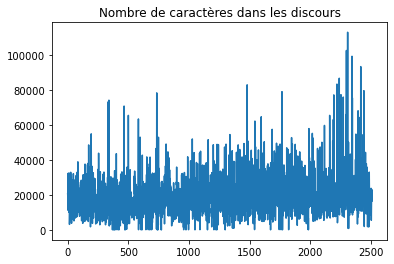

In [9]:
# Test sur la longueur du contenu des discours
print("Nombre moyen de caractères dans les discours : ",df.contents.str.len().mean())
print("Minimum de caractères dans les discours : ", df.contents.str.len().min())
print("Maximum de caractères dans les discours : ", df.contents.str.len().max())
df.contents.str.len().plot(title="Nombre de caractères dans les discours")

Nombre moyen de caractères dans les titres :  60.748903945795135
Minimum de caractères dans les titres :  5
Maximum de caractères dans les titres :  231


<AxesSubplot:title={'center':'Nombre de caractères dans les titres'}>

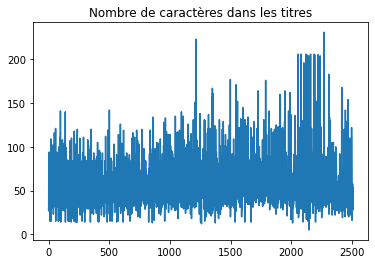

In [10]:
#Test sur la longueur des titres
print("Nombre moyen de caractères dans les titres : ",df.title.str.len().mean())
print("Minimum de caractères dans les titres : ", df.title.str.len().min())
print("Maximum de caractères dans les titres : ", df.title.str.len().max())
df.title.str.len().plot(title="Nombre de caractères dans les titres")

## Modèle de détection (spacy)

In [11]:

def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load('en_core_web_lg')
# la ligne suivante doit être mise en commentaire si ce n'est pas la première fois qu'on exécute le notebook
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)
text = 'This is an english text.'
doc = nlp(text)
print(doc._.language)


{'language': 'en', 'score': 0.9999971376102275}


In [12]:
doc._.language["language"]

'en'

## Avec les titres 

In [13]:
start = time.time()
EN=0
OTHERS=0
L=[]
I0=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["title"][i]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I0.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""
Proportion de discours en anglais :  0.8999601434834595
Temps pris par cette méthode : 25.839558839797974
"""

Proportion de discours en anglais :  0.9007572738142686
Temps pris par cette méthode : 28.507774114608765


'\nProportion de discours en anglais :  0.8999601434834595\nTemps pris par cette méthode : 25.839558839797974\n'

## Avec les 1000 premiers caractères du discours

In [14]:
start = time.time()
EN=0
OTHERS=0
L=[]
I1=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["contents"][i][:1000]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I1.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""Proportion de discours en anglais :  0.9182941410920685
Temps pris par cette méthode : 80.60761404037476"""

Proportion de discours en anglais :  0.9174970107612594
Temps pris par cette méthode : 84.7314248085022


'Proportion de discours en anglais :  0.9182941410920685\nTemps pris par cette méthode : 80.60761404037476'

## Avec le début du discours privé de la répétition du titre

In [15]:
start = time.time()
EN=0
OTHERS=0
L=[]
I2=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["contents"][i][200:2000]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I2.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""Proportion de discours en anglais :  0.9286568353925867
Temps pris par cette méthode : 129.33490419387817"""

Proportion de discours en anglais :  0.9278597050617776
Temps pris par cette méthode : 134.50130367279053


'Proportion de discours en anglais :  0.9286568353925867\nTemps pris par cette méthode : 129.33490419387817'

## Avec les 2000 premiers caractères

In [16]:
start = time.time()
EN=0
OTHERS=0
L=[]
I3=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["contents"][i][:2000]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I3.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""Proportion de discours en anglais :  0.9290554005579912
Temps pris par cette méthode : 143.3227822780609"""

Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 145.1390459537506


'Proportion de discours en anglais :  0.9290554005579912\nTemps pris par cette méthode : 143.3227822780609'

# Modèle de détection langdetect

In [17]:
#!pip install langdetect
from langdetect import detect

In [18]:
# Extrait de la documentation https://pypi.org/project/langdetect/#description
# langdetect Language detection algorithm is non-deterministic,
# which means that if you try to run it on a text which is either too short or too ambiguous,
# you might get different results everytime you run it.
# To enforce consistent results, call following code before the first language detection:

from langdetect import DetectorFactory
DetectorFactory.seed = 0

## Avec les titres 

In [19]:
start = time.time()
EN=0
OTHERS=0
L=[]
J0=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["title"][i])
    if s=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        J0.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print(end - start) 

# Quelques centaines de discours dans d'autres langues (français, allemand, espagnol, italien, néerlandais,...)
# Cependant on constate qu'il reste des discours en français et en allemand non mis de coté
# Certains discours en anglais sont mis de côté de manière injustifiée

"""Proportion de discours en anglais :  0.9035472299721005
Temps pris par cette méthode : 12.753894805908203"""

Proportion de discours en anglais :  0.8983658828218414
13.771211862564087


'Proportion de discours en anglais :  0.9035472299721005\nTemps pris par cette méthode : 12.753894805908203'

## Avec les 1000 premiers caractères

In [20]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J1=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][:1000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J1.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.917098445595855
Temps pris par cette méthode : 13.944712400436401
"""

Proportion de discours en anglais :  0.9182941410920685
Temps pris par cette méthode : 15.606242656707764


'\nProportion de discours en anglais :  0.917098445595855\nTemps pris par cette méthode : 13.944712400436401\n'

## Avec les 2000 premiers caractères mais sans les 200 premiers

In [21]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J2=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][200:2000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J2.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.9278597050617776
Temps pris par cette méthode : 20.057332754135132
"""

Proportion de discours en anglais :  0.9286568353925867
Temps pris par cette méthode : 20.978902339935303


'\nProportion de discours en anglais :  0.9278597050617776\nTemps pris par cette méthode : 20.057332754135132\n'

## Avec les 2000 premiers caractères

In [22]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J3=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][:2000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J3.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 19.53878378868103
"""

Proportion de discours en anglais :  0.9286568353925867
Temps pris par cette méthode : 22.730217456817627


'\nProportion de discours en anglais :  0.9294539657233958\nTemps pris par cette méthode : 19.53878378868103\n'

## Avec les 5000 premiers caractères

In [23]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J4=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][:5000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J4.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.936229573535273
Temps pris par cette méthode : 37.724875688552856
"""

Proportion de discours en anglais :  0.9366281387006775
Temps pris par cette méthode : 44.064444065093994


'\nProportion de discours en anglais :  0.936229573535273\nTemps pris par cette méthode : 37.724875688552856\n'

## Comparaison des méthodes

In [24]:
liste=[I0,I1,I2,I3,J0,J1,J2,J3,J4]
for L in liste:
    print(len(L))

249
207
181
177
255
205
179
179
159


In [25]:
#Comparaison des deux méthodes analysant uniquement les titres 
print([value for value in J0 if value not in I0]) #vérification à la main : titre "trompeur" mais contenu en anglais (sauf 1)
print([value for value in I0 if value not in J0]) #vérification à la main : contenu en anglais
# Les deux méthodes de détection via les titres semblent semblables mais assez peu efficaces 

[12, 193, 231, 275, 475, 491, 546, 562, 697, 854, 1002, 1023, 1644, 1822, 1878]
[361, 657, 1333, 1374, 1491, 1720, 1945, 1979, 2015]


On peut observer un problème avec les discours de Jean-Claude Trichet, president de l'ECB de 2003 à 2011, qui commence (et parfois termine ) toutes ses interventions en français, parfois en allemand.
Alors que tous les discours sont en anglais.

In [26]:
# Comparaison des résultats des méthodes analysant les 2000 premiers caractères privés des titres
print([value for value in J2 if value not in I2])
print([value for value in I2 if value not in J2])
# Tous ce discours contiennent des phrases en allemand et/ou en français.

[]
[1137, 1535]


In [27]:
#En prenant en compte ou non les débuts de discours
print([value for value in I2 if value not in I3]) # toujours le problème avec les discours de Jean Claude Trichet 
print([value for value in I3 if value not in I2]) #discours très court en allemand 1758


[1137, 1482, 1535, 1902, 1977]
[1758]


In [28]:
print([value for value in J2 if value not in J3]) 
print([value for value in J3 if value not in J2]) 

[1179, 1662, 1902]
[1137, 1535, 1758]


In [29]:
print([value for value in I3 if value not in J3]) 
print([value for value in J3 if value not in I3]) 

[1179, 1662]
[1137, 1482, 1535, 1977]


In [30]:
for i in [value for value in I3 if value not in J3]:
    print(df["speakers"][i]," - ",df["title"][i])

Jean-Claude Trichet  -  The ECB's response to the crisis
Jean-Claude Trichet  -  Hearing at the Economic and Monetary Affairs Committee of the European Parliament


In [31]:
for i in [value for value in J3 if value not in J4]:
    print(df["speakers"][i]," - ",df["title"][i])

Jean-Claude Trichet  -  Hearing at the Committee on Economic and Monetary Affairs of the European Parliament
Jean-Claude Trichet  -  Hearing at the Committee on Economic and Monetary Affairs of the European Parliament
Jean-Claude Trichet  -  Hearing at the Committee on Economic and Monetary Affairs of the European Parliament
Jean-Claude Trichet  -  Hearing before the plenary of the European Parliament on the occasion of the adoption of the EP resolution on the ECB's 2009 Annual Report
Jean-Claude Trichet  -  Lessons from the financial crisis
Jean-Claude Trichet  -  Hearing before the Economic and Monetary Affairs Committee of the European Parliament
Jean-Claude Trichet  -  Macroeconomic policies, imbalances and the need to avoid going back to the status quo ante
Jean-Claude Trichet  -  Hearing at the Economic and Monetary Affairs Committee of the European Parliament
Jean-Claude Trichet  -  Ehrenplaquette of the city of Frankfurt am Main - awarding ceremony
Jean-Claude Trichet  -  Heari

In [32]:
#Comparaison qui semble la plus intéressante entre les deux méthodes
print([value for value in I3 if value not in J2]) 
print([value for value in J2 if value not in I3]) 

[1758]
[1482, 1902, 1977]


In [33]:
#df["contents"][1758] #discours très court et en allemand

In [34]:
n=random.sample([value for value in I3 if value not in J3],1)[0]
df["contents"][n]

"  Hearing at the Economic and Monetary Affairs Committee of the European Parliament   Jean-Claude Trichet, President of the ECBBrussels, 9 October 2007 Madame la Présidente, Mesdames et Messieurs les membres de la Commission Economique et Monétaire, je me réjouis d'apparaître devant votre commission aujourd'hui et de poursuivre notre dialogue fructueux. La situation sur les marchés financiers suscite toujours beaucoup d’intérêt. Aujourd’hui, je reviendrai d’abord brièvement sur la situation économique et monétaire, en expliquant les raisons sous-jacentes à nos récentes décisions de taux. Ensuite, je vous fournirai de plus amples informations sur les opérations de politique monétaire de la BCE en réaction aux tensions enregistrées sur le marché monétaire ainsi que sur les initiatives en cours visant à améliorer le cadre relatif à la réglementation, à la surveillance et à la stabilité financières. Schließlich möchte ich ein paar Anmerkungen machen zu den Produktivitätsentwicklungen in E

## Autre modèle de détection de langage ?

In [35]:
#Autre idée : supprimer "à la main" les discours passant à travers les mailles du filet
# utiliser les articles/prépositions les plus courants : le/la/de ou die/fur

 ## Conclusion vis-à-vis des différentes méthodes

Même si les méthodes de détection de langages ave les titres uniquement sont plus rapides, elles entrainent beaucoup d'erreurs (trop de faux positifs). La difficulté de la détection vient en grande partie des discours de Jean Claude Trichet qui comportent plusieurs langues dont l'anglais.

On peut considérer que les discours en plusieurs langues (comme ceux de Jean-Claude Trichet) ne sont pas gênants car ils sont majoritairement en anglais. Il faut juste penser à adapter les stopwords en conséquence.

Par ailleurs, on peut remarquer que les méthodes de langdetect sont beaucoup plus rapides que celles de spacy pour des résultats équivalents (voire identiques). La méthode qui paraît la plus efficace pour cette détection est celle qui utilise langdetect en analysant les 2000 premiers caractères de chaque discours.

## Modification du dataframe

In [36]:
#df["Language"]=pd.Series(dtype=str)
#On pourrait ajouter une colonne "language" pour une analyse ultérieure

In [37]:
# On va donc retirer ces discours des données à analyser
I=J3
df=df.drop(I).reset_index(drop=True)
df

date              speakers  \
0     2021-11-29     Christine Lagarde   
1     2021-11-26     Christine Lagarde   
2     2021-11-25        Frank Elderson   
3     2021-11-24         Fabio Panetta   
4     2021-11-22       Luis de Guindos   
...          ...                   ...   
2325  1997-05-13  Alexandre Lamfalussy   
2326  1997-04-30  Alexandre Lamfalussy   
2327  1997-04-22  Alexandre Lamfalussy   
2328  1997-03-10  Alexandre Lamfalussy   
2329  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0                          Dialogue in a changing world   
1                          Change and continuity in law   
2     When you need change to preserve continuity: c...   
3         Patient monetary policy amid a rocky recovery   
4     Ralph Koijen’s contribution to research on the...   
...                                                 ...   
2325  The European Central Bank: independent and acc...   
2326  The operation of monetary policy in stage thre...   
2327  Convergence and the role of the European Centr...   
2328                       Securing the benefits of EMU   
2329  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lectio Magistralis by Christine Lagarde, Presi...   
1     Keynote speech by Christine Lagarde, President...   
2     Speech by Frank Elderson, Member of the Execut...   
3     Speech by Fabio Panetta, Member of the Executi...   
4     Remarks by Luis de Guindos, Vice-President of ...   
...                                                 ...   
2325  Keynote speech delivered by Alexandre Lamfalus...   
2326  Address by Alexandre Lamfalussy, President of ...   
2327  Remarks by Alexandre Lamfalussy, President of ...   
2328  Address by Alexandre Lamfalussy, President of ...   
2329  Address by Alexandre Lamfalussy, President of ...   

                                               contents  
0        SPEECH  Dialogue in a changing world   Lect...  
1        SPEECH  Change and continuity in law   Keyn...  
2        SPEECH  When you need change to preserve co...  
3        SPEECH  Patient monetary policy amid a rock...  
4        SPEECH  Ralph Koijen’s contribution to rese...  
...                                                 ...  
2325    The European Central Bank: independent and a...  
2326    The operation of monetary policy in stage th...  
2327    Convergence and the role of the European Cen...  
2328    Securing the benefits of EMU   Address by Al...  
2329    Conference organised by the Hungarian Bankin...  

[2330 rows x 5 columns]

In [38]:
df.sample(5)

date               speakers  \
921   2013-06-10           Benoît Cœuré   
343   2018-04-27            Yves Mersch   
1680  2006-10-16    Jean-Claude Trichet   
502   2017-03-27  Sabine Lautenschläger   
1213  2010-10-12    Jean-Claude Trichet   

                                                  title  \
921               Monetary policy in a fragmented world   
343     Reflections on monetary policy in the euro area   
1680  How to elevate the potential growth rate of Eu...   
502   Digital na(t)ive? Fintechs and the future of b...   
1213  Europe's frameworks for macro-prudential overs...   

                                               subtitle  \
921   Speech by Benoît Cœuré, Member of the Executiv...   
343   Speaking points by Yves Mersch, Member of the ...   
1680  Speech by Jean-Claude Trichet, President of th...   
502   Statement by Sabine Lautenschläger, Member of ...   
1213  Speech by Jean-Claude Trichet, President of th...   

                                               contents  
921     Monetary policy in a fragmented world   Spee...  
343     Reflections on monetary policy in the euro a...  
1680    How to elevate the potential growth rate of ...  
502     Digital na(t)ive? Fintechs and the future of...  
1213    Europe’s frameworks for macro-prudential ove...

On crée trois colonnes pour le jour, le mois et l'année qu'on établit à partir de la date.

In [39]:

df["Year"]=df.date.str[:4].astype(int)
df["Month"]=df.date.str[5:7].astype(int)
df["Day"]=df.date.str[8:].astype(int)


In [40]:
week=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
months=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df["DayofWeek"]=pd.Series(dtype=int)
df["DayofWeek_str"]=pd.Series(dtype=str)
df["Month_str"]=pd.Series(dtype=str)
for i in range(len(df)):
    df["DayofWeek"][i]=int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).isoweekday())
    df["DayofWeek_str"][i]=week[int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).weekday())]
    df["Month_str"][i]=months[df["Month"][i]-1]

#.weekday() : from 0 to 6
#.isoweekday() : from 1 to 7

df["DayofWeek"]=df["DayofWeek"].astype(int)

C:\Users\Antoine\AppData\Local\Temp/ipykernel_50772/494173469.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DayofWeek"][i]=int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).isoweekday())
C:\Users\Antoine\AppData\Local\Temp/ipykernel_50772/494173469.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DayofWeek_str"][i]=week[int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).weekday())]
C:\Users\Antoine\AppData\Local\Temp/ipykernel_50772/494173469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

In [41]:
df

date              speakers  \
0     2021-11-29     Christine Lagarde   
1     2021-11-26     Christine Lagarde   
2     2021-11-25        Frank Elderson   
3     2021-11-24         Fabio Panetta   
4     2021-11-22       Luis de Guindos   
...          ...                   ...   
2325  1997-05-13  Alexandre Lamfalussy   
2326  1997-04-30  Alexandre Lamfalussy   
2327  1997-04-22  Alexandre Lamfalussy   
2328  1997-03-10  Alexandre Lamfalussy   
2329  1997-02-07  Alexandre Lamfalussy   

                                                  title  \
0                          Dialogue in a changing world   
1                          Change and continuity in law   
2     When you need change to preserve continuity: c...   
3         Patient monetary policy amid a rocky recovery   
4     Ralph Koijen’s contribution to research on the...   
...                                                 ...   
2325  The European Central Bank: independent and acc...   
2326  The operation of monetary policy in stage thre...   
2327  Convergence and the role of the European Centr...   
2328                       Securing the benefits of EMU   
2329  Conference organised by the Hungarian Banking ...   

                                               subtitle  \
0     Lectio Magistralis by Christine Lagarde, Presi...   
1     Keynote speech by Christine Lagarde, President...   
2     Speech by Frank Elderson, Member of the Execut...   
3     Speech by Fabio Panetta, Member of the Executi...   
4     Remarks by Luis de Guindos, Vice-President of ...   
...                                                 ...   
2325  Keynote speech delivered by Alexandre Lamfalus...   
2326  Address by Alexandre Lamfalussy, President of ...   
2327  Remarks by Alexandre Lamfalussy, President of ...   
2328  Address by Alexandre Lamfalussy, President of ...   
2329  Address by Alexandre Lamfalussy, President of ...   

                                               contents  Year  Month  Day  \
0        SPEECH  Dialogue in a changing world   Lect...  2021     11   29   
1        SPEECH  Change and continuity in law   Keyn...  2021     11   26   
2        SPEECH  When you need change to preserve co...  2021     11   25   
3        SPEECH  Patient monetary policy amid a rock...  2021     11   24   
4        SPEECH  Ralph Koijen’s contribution to rese...  2021     11   22   
...                                                 ...   ...    ...  ...   
2325    The European Central Bank: independent and a...  1997      5   13   
2326    The operation of monetary policy in stage th...  1997      4   30   
2327    Convergence and the role of the European Cen...  1997      4   22   
2328    Securing the benefits of EMU   Address by Al...  1997      3   10   
2329    Conference organised by the Hungarian Bankin...  1997      2    7   

      DayofWeek DayofWeek_str Month_str  
0             1        Monday  November  
1             5        Friday  November  
2             4      Thursday  November  
3             3     Wednesday  November  
4             1        Monday  November  
...         ...           ...       ...  
2325          2       Tuesday       May  
2326          3     Wednesday     April  
2327          2       Tuesday     April  
2328          1        Monday     March  
2329          5        Friday  February  

[2330 rows x 11 columns]

<AxesSubplot:xlabel='Year'>

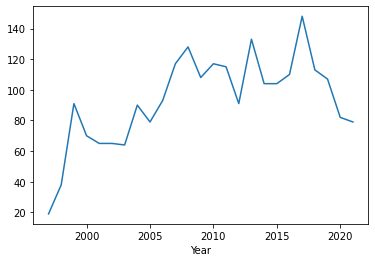

In [42]:
df_year=df.groupby("Year").count()
df_year["date"].plot()

<AxesSubplot:xlabel='Month'>

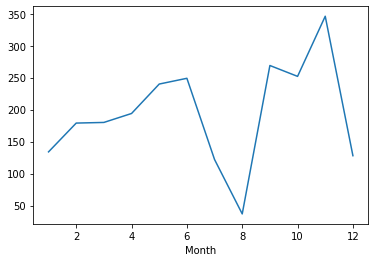

In [43]:
df_month=df.groupby("Month").count()
df_month["date"].plot()

<AxesSubplot:xlabel='Day'>

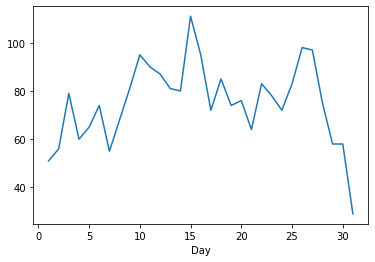

In [44]:
df_day=df.groupby("Day").count()
df_day["date"].plot()

<AxesSubplot:xlabel='DayofWeek'>

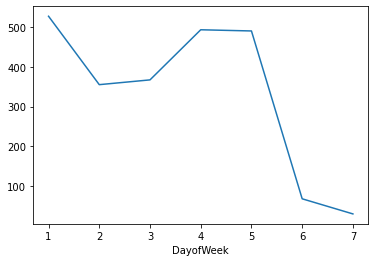

In [45]:
df_day=df.groupby("DayofWeek").count()
df_day["date"].plot()

## Analyse préliminaire des données 

<AxesSubplot:xlabel='Year,Month,Day,DayofWeek'>

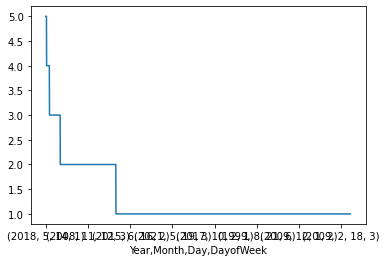

In [46]:
df[["Year","Month","Day","DayofWeek"]].value_counts().plot()
# Graphique très laid mais qui permet de voir qu'il y a un nombre de jours non négligeable pour lesquels il y a eu plusieurs discours


Text(0.5, 1.0, 'On what days of the week are ECB speeches delivered?')

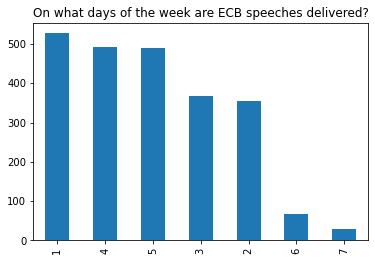

In [47]:
#df["DayofWeek"].value_counts().barplot()

plt.figure()

df["DayofWeek"].value_counts().plot(kind="bar")
plt.title("On what days of the week are ECB speeches delivered?")

In [48]:
array=df["DayofWeek"].value_counts().to_numpy()
array

array([527, 493, 490, 367, 355,  68,  30], dtype=int64)

Text(0.5, 1.0, 'Which day are ECB speeches delivered?')

<Figure size 432x288 with 0 Axes>

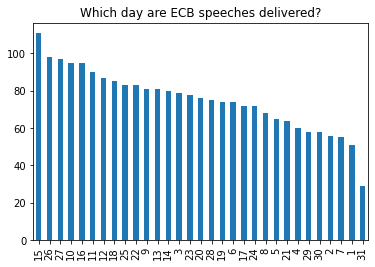

In [49]:
plt.clf()
plt.figure()

df["Day"].value_counts().plot(kind="bar")
plt.title("Which day are ECB speeches delivered?")

Text(0.5, 1.0, 'On which month are ECB speeches delivered?')

<Figure size 432x288 with 0 Axes>

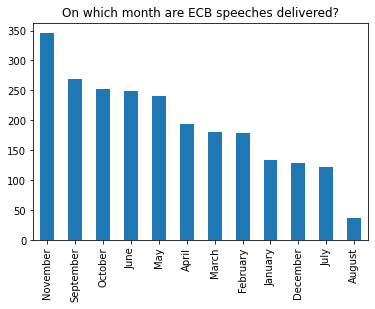

In [50]:
plt.clf()
plt.figure()

df["Month_str"].value_counts().plot(kind="bar")
plt.title("On which month are ECB speeches delivered?")

Text(0.5, 1.0, 'ECB Speeches over the years')

<Figure size 432x288 with 0 Axes>

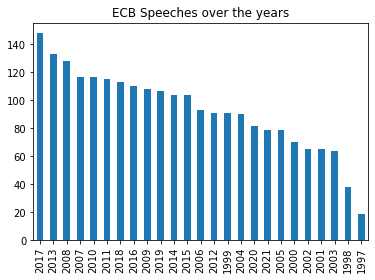

In [51]:
plt.clf()
plt.figure()

df["Year"].value_counts().plot(kind="bar")
plt.title("ECB Speeches over the years")

Text(0.5, 1.0, 'Top 15 ECB Speakers')

<Figure size 432x288 with 0 Axes>

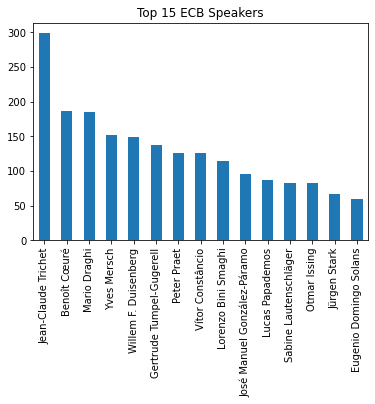

In [52]:
plt.clf()
plt.figure()

df["speakers"].value_counts()[:15].plot(kind="bar")

plt.title("Top 15 ECB Speakers")

In [53]:
df["contents"][21]

'   SPEECH  Globalisation after the pandemic   2021 Per Jacobsson Lecture by Christine Lagarde, President of the ECB, at the IMF Annual Meetings IMF Annual Meetings, 16 October 2021 It is a pleasure to be back in Washington and to deliver this year’s Per Jacobsson Lecture. As a young man in the 1920s, Jacobsson worked in the Economic and Financial Section of the League of Nations Secretariat. There, he was actively involved in work on Europe’s financial reconstruction in the wake of the greatest shock that had hit the continent: the First World War. The outbreak of that conflict in 1914, which killed so many and injured even more, marked the end of the first era of globalisation. The unprecedented flows of trade that had characterised the global economy between the 1870s and the early 1900s collapsed, as borders were replaced by battlelines.  The pre-war world quickly became, as the writer Stefan Zweig put it, “the world of yesterday”. This shows how fast what had once seemed so perman

## Début de l'analyse pour le NLP

In [54]:
rawtext=''
L=random.sample(range(len(df)),15)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [55]:
rawtext

'Opening statement at the Commission Conference “Building a Crisis Management Framework for the Internal Market”  Opening statement at the Commission Conference “Building a Crisis Management Framework for the Internal Market”   Speech by Jean-Claude Trichet, President of the ECB,Brussels, 19 March 2010 Ladies and Gentlemen, I would like to thank the Commission for inviting me to today’s conference. I trust that the discussion will help to identify avenues that will strengthen the European Union’s framework for crisis management and resolution for the years to come.   The evolving crisis Reflecting on the crisis from today’s perspective, I would say that what is now called ‘the crisis’ is a deeply evolving phenomenon. It evolved from a crisis of liquidity into a full-scale crisis of banking and finance, and then into a global financial and economic crisis. And as we are all well aware, a great deal of attention is currently focused on fiscal policy and public finances.  At the same time

In [56]:
# Reconnaissance des entités nommées
from spacy import displacy

nlp = spacy.load("en_core_web_lg")
doc = nlp(rawtext)
displacy.render(doc, style="ent", jupyter=True)

In [57]:
#Il faut définir un liste de stopwords (c'est-à-dire de mots non significatifs) 
#En anglais 
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [58]:

alphabet=set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ') #type(alphabet)=set "ensemble"
stop_words= stop_words | alphabet # On fait une union d'ensembles pour retirer des nuages de mots les lettres isolées
#L'étape précédeente peut êtr évitée en spécifiant min_word_length=2 dans la fonction WordCloud
wordlist=['The','It','And','this','This','The','the','these','These','those','Those','In','&','one','He','She','he','she','it','\\displaystyle','\\mathbb','\\neg','per','th','also','would','de','la']
stop_words.update(wordlist) #on ajoute des mots aux 'stopwords'

In [59]:
#Fonction qui permet d'obtenir une liste de mots en minuscules sans les stopwords

def str_to_wordlist(text):
    text2 = c.copy(text)
    text2 = text2.lower() # minuscules
    text2 = re.sub(r'\d+','',text2) # enlever les nombres
    text2 = re.findall(r'\w+', text2) # enlever la ponctuation
    text2 = [word for word in text2 if not word in stop_words and len(word)>2] # enlever les stopwords
    return(text2)

#text = str_to_wordlist(text)

In [60]:
def freq_dict(text):
    res = {}
    for word in text:
        try:
            res[word] += 1
        except KeyError:
            res[word] = 1
    return(res)


#dictionary = freq_dict(rawtext)

In [61]:
"Fonction pour récupérer les fréquences des mots d'un texte"

def freq_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+','',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    return collections.Counter(T)


In [62]:
freq_mots(rawtext,stop_words)

Counter({'Opening': 3,
         'statement': 4,
         'Commission': 30,
         'Conference': 7,
         'Building': 2,
         'Crisis': 2,
         'Management': 4,
         'Framework': 5,
         'Internal': 5,
         'Market': 6,
         'Speech': 11,
         'Jean': 2,
         'Claude': 2,
         'Trichet': 2,
         'President': 7,
         'ECB': 169,
         'Brussels': 5,
         'March': 19,
         'Ladies': 9,
         'Gentlemen': 4,
         'like': 38,
         'thank': 5,
         'inviting': 3,
         'today': 38,
         'conference': 11,
         'trust': 4,
         'discussion': 11,
         'help': 24,
         'identify': 3,
         'avenues': 1,
         'strengthen': 13,
         'European': 101,
         'Union': 18,
         'framework': 28,
         'crisis': 147,
         'management': 23,
         'resolution': 19,
         'years': 53,
         'come': 16,
         'evolving': 5,
         'Reflecting': 1,
         'perspective': 11

In [63]:
"Fonction pour récupérer la liste des mots d'un texte brut"
def liste_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    return [mot for mot in text.split() if mot not in list(stopwords)]

In [64]:
liste_mots(rawtext,stop_words)

['Opening',
 'statement',
 'Commission',
 'Conference',
 'Building',
 'Crisis',
 'Management',
 'Framework',
 'Internal',
 'Market',
 'Opening',
 'statement',
 'Commission',
 'Conference',
 'Building',
 'Crisis',
 'Management',
 'Framework',
 'Internal',
 'Market',
 'Speech',
 'Jean',
 'Claude',
 'Trichet',
 'President',
 'ECB',
 'Brussels',
 'March',
 'Ladies',
 'Gentlemen',
 'like',
 'thank',
 'Commission',
 'inviting',
 'today',
 'conference',
 'trust',
 'discussion',
 'help',
 'identify',
 'avenues',
 'strengthen',
 'European',
 'Union',
 'framework',
 'crisis',
 'management',
 'resolution',
 'years',
 'come',
 'evolving',
 'crisis',
 'Reflecting',
 'crisis',
 'today',
 'perspective',
 'say',
 'called',
 'crisis',
 'deeply',
 'evolving',
 'phenomenon',
 'evolved',
 'crisis',
 'liquidity',
 'full',
 'scale',
 'crisis',
 'banking',
 'finance',
 'global',
 'financial',
 'economic',
 'crisis',
 'well',
 'aware',
 'great',
 'deal',
 'attention',
 'currently',
 'focused',
 'fiscal',
 'po

In [65]:
"Fonction pour récupérer les n mots les plus fréquents (hors stopwords) dans un texte brut"
def plus_frequents(text,n,stopwords):
    L=[]
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    for tuple in collections.Counter(T).most_common(n):
        L.append([tuple[0],tuple[1]])
    return L

In [66]:
n=20
plus_frequents(rawtext,n,stop_words)

[['euro', 334],
 ['policy', 280],
 ['area', 259],
 ['monetary', 221],
 ['financial', 220],
 ['ECB', 170],
 ['banks', 169],
 ['crisis', 147],
 ['countries', 139],
 ['inflation', 132],
 ['rate', 123],
 ['market', 122],
 ['markets', 113],
 ['term', 112],
 ['stability', 111],
 ['rates', 111],
 ['European', 101],
 ['growth', 99],
 ['interest', 96],
 ['central', 93]]

In [67]:
rawtext=''
L=random.sample(range(len(df)),50)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [68]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

#example_sent = "This is a sample sentence,showing off the stop words filtration."

def tokens_filter(text,stop_words):
    word_tokens = tokenizer.tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] #retire les stopwords
    return filtered_sentence

text=tokens_filter(rawtext,stop_words)

In [69]:
collections.Counter(text).most_common(20)

[('euro', 1025),
 ('financial', 890),
 ('policy', 836),
 ('area', 782),
 ('monetary', 628),
 ('ECB', 578),
 ('banks', 510),
 ('market', 497),
 ('European', 453),
 ('central', 383),
 ('markets', 367),
 ('economic', 366),
 ('countries', 341),
 ('stability', 332),
 ('term', 299),
 ('crisis', 288),
 ('price', 279),
 ('risk', 279),
 ('bank', 277),
 ('growth', 267)]

## les n-grams

In [70]:
nltk.download('genesis')
nltk.corpus.genesis.words('english-web.txt')

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\Antoine\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!


['In', 'the', 'beginning', 'God', 'created', 'the', ...]

In [71]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

## Bigrams
finder = BigramCollocationFinder.from_words(
   text)
# only bigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(bigram_measures.likelihood_ratio, 10))

for i in finder.score_ngrams(bigram_measures.likelihood_ratio):
    print (i)

(('euro', 'area'), 6384.95579926657)
(('monetary', 'policy'), 3189.1425223901606)
(('price', 'stability'), 1771.480558565625)
(('central', 'banks'), 1390.7393934573747)
(('central', 'bank'), 1060.930935312429)
(('United', 'States'), 1021.0087140312712)
(('medium', 'term'), 984.4220781949923)
(('Governing', 'Council'), 957.8293894779938)
(('interest', 'rates'), 937.3448421706601)
(('Central', 'Bank'), 900.420856982058)
(('Member', 'States'), 888.2532038142377)
(('cross', 'border'), 843.458842211093)
(('financial', 'system'), 832.5935315269548)
(('Monetary', 'Union'), 714.4067659746161)
(('balance', 'sheet'), 679.7589613294259)
(('Executive', 'Board'), 644.7294439102465)
(('long', 'term'), 619.6708730123958)
(('short', 'term'), 613.009534013182)
(('exchange', 'rate'), 559.2142310728186)
(('European', 'Central'), 544.7620831432425)
(('banking', 'sector'), 534.3106028841536)
(('Federal', 'Reserve'), 531.0569849129911)
(('refinancing', 'operations'), 511.14666106827553)
(('market', 'partici

In [72]:
## Trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()


finder = TrigramCollocationFinder.from_words(
   text)
# only trigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(trigram_measures.likelihood_ratio, 10))
for i in finder.score_ngrams(trigram_measures.likelihood_ratio):
    print (i)

(('euro', 'area', 'countries'), 6580.860779216167)
(('across', 'euro', 'area'), 6500.503174085347)
(('outside', 'euro', 'area'), 6499.863997607952)
(('euro', 'area', 'economy'), 6491.999905854118)
(('euro', 'area', 'whole'), 6450.304899982313)
(('euro', 'area', 'banks'), 6431.342564569432)
(('euro', 'area', 'wide'), 6429.509626931108)
(('stability', 'euro', 'area'), 6423.604787617682)
(('euro', 'area', 'financial'), 6420.837323923406)
(('role', 'euro', 'area'), 6419.220292335094)
(('euro', 'area', 'banking'), 6418.1290110263635)
(('competitiveness', 'euro', 'area'), 6416.527980083978)
(('euro', 'area', 'insurers'), 6415.733195721687)
(('euro', 'area', 'government'), 6414.503911308562)
(('euro', 'area', 'LCBGs'), 6414.043009758103)
(('representation', 'euro', 'area'), 6412.718531591016)
(('States', 'euro', 'area'), 6412.460783133951)
(('join', 'euro', 'area'), 6409.756457858573)
(('PDF', 'euro', 'area'), 6409.542725479461)
(('throughout', 'euro', 'area'), 6408.88351409262)
(('euro', 'ar

In [73]:
#Lemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()
 
print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))
 
# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos ="a"))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Antoine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


rocks : rock
corpora : corpus
better : good


In [74]:
lemmatizer.lemmatize("thieves")

'thief'

In [75]:
#Most frequent words by year
years=df["Year"].unique()

def year_speeches(df,year):
    #df : pandas dataframe
    #year : int
    text=''
    df_year=df[df["Year"] == year].reset_index(drop=True)
    for i in range(len(df_year)):
        text+=df_year["title"][i]+df_year["contents"][i]
    return text



In [76]:
year=2010
year_speeches(df,year)

'Introductory remarks at the International Club of Economic Journalists  Introductory remarks at the International Club of Economic Journalists   Jean-Claude Trichet, President of the European Central Bank, Frankfurt am Main, 13 December 2010 Ladies and Gentlemen, It is a true pleasure for me to participate in the meeting co-organised with the International Club of Frankfurt Economic Journalists. I vividly remember the interesting discussions we had in December 2008. At the time, I took the opportunity to discuss the changes in central banking communication. Today, I would like to focus on the current situation regarding Economic and Monetary Union.  Let me start by quoting from a famous speech that, according to the ancient Greek historian Thucydides, the Athenian statesman and leader Pericles delivered to his fellow citizens during the Peloponnesian War more than 2400 years ago:  “Our constitution does not copy the laws of neighbouring states; we are rather a pattern to others than i

In [77]:
def freq_words_year(df,year,n=10):
    #df : pandas dataframe
    #year : int
    #n : int
    text=year_speeches(df,year)
    return collections.Counter(tokens_filter(text,stop_words)).most_common(n)

In [78]:
year=2008
df_year=df[df["Year"] == year].reset_index(drop=True)
df_year

date             speakers  \
0    2008-12-15  Jean-Claude Trichet   
1    2008-12-15      Lucas Papademos   
2    2008-12-11  Jean-Claude Trichet   
3    2008-12-10         Jürgen Stark   
4    2008-12-09  Lorenzo Bini Smaghi   
..          ...                  ...   
123  2008-01-16  Jean-Claude Trichet   
124  2008-01-16         Jürgen Stark   
125  2008-01-12  Jean-Claude Trichet   
126  2008-01-05      Lucas Papademos   
127  2008-01-05  Jean-Claude Trichet   

                                                 title  \
0                   The changing role of communication   
1    Opening remarks  at the press briefing on the ...   
2                       European Financial Integration   
3    Issues paper for the conference "The financial...   
4    The Financial Crisis and Global Imbalances: Tw...   
..                                                 ...   
123    A few remarks on communication by central banks   
124  Knowns and unknowns about the creation of econ...   
125   The successful entry of Malta into the euro area   
126    Monetary policy communication and effectiveness   
127  Remarks at the meeting of the Management Board...   

                                              subtitle  \
0    Introductory Remarks by Jean-Claude Trichet, P...   
1    Speech by Lucas Papademos, Vice President of t...   
2    Speech by Jean-Claude Trichet, President of th...   
3    Speech by Jürgen Stark, Member of the Executiv...   
4    Speech by Lorenzo Bini Smaghi, Member of the E...   
..                                                 ...   
123  Keynote address by Jean-Claude Trichet, Presid...   
124  Speech by Jürgen Stark, Member of the Executiv...   
125  Speech by Jean-Claude Trichet, President of th...   
126  Speech by Lucas Papademos, Vice President of t...   
127  Speech by Jean-Claude Trichet, President of th...   

                                              contents  Year  Month  Day  \
0      The changing role of communication   Introdu...  2008     12   15   
1      Opening remarks at the press briefing on the...  2008     12   15   
2      European Financial Integration   Speech by J...  2008     12   11   
3      Issues paper for the conference "The financi...  2008     12   10   
4      The Financial Crisis and Global Imbalances: ...  2008     12    9   
..                                                 ...   ...    ...  ...   
123    A few remarks on communication by central ba...  2008      1   16   
124    Knowns and unknowns about the creation of ec...  2008      1   16   
125    The successful entry of Malta into the euro ...  2008      1   12   
126    Monetary policy communication and effectiven...  2008      1    5   
127    Remarks at the meeting of the Management Boa...  2008      1    5   

     DayofWeek DayofWeek_str Month_str  
0            1        Monday  December  
1            1        Monday  December  
2            4      Thursday  December  
3            3     Wednesday  December  
4            2       Tuesday  December  
..         ...           ...       ...  
123          3     Wednesday   January  
124          3     Wednesday   January  
125          6      Saturday   January  
126          6      Saturday   January  
127          6      Saturday   January  

[128 rows x 11 columns]

In [79]:
df_year["contents"][0]

"  The changing role of communication   Introductory Remarks by Jean-Claude Trichet, President of the ECBat a dinner with members of the Internationaler Club Frankfurter Wirtschaftsjournalisten Frankfurt am Main,15 December 2008 Ladies and gentlemen,  A very warm welcome to all of you and thank you very much for your invitation to this club evening. I am happy to see many familiar faces in the audience tonight. Communication is a very important issue for all times. Being here in Frankfurt I am thinking of the very profound remark by Goethe: “Niemand würde in Gesellschaften viel sprechen, wenn er sich bewuβt wäre, wie oft er die anderen missversteht“. Nevertheless let me be bold enough to share with you some thoughts on communication and central banks. Communication is a key element for central banks to enhance the effectiveness, predictability and credibility of their monetary policy decisions. It becomes even more important in difficult times, when the economic outlook darkens and con

In [80]:
year=2005
L=freq_words_year(df,year,20)
x=[]
y=[]
z=[]
for i in range(len(L)):
    x.append(L[i][0])
    y.append(L[i][1])
    z.append(round(100*L[i][1]/L[0][1],1))


<BarContainer object of 20 artists>

<Figure size 432x288 with 0 Axes>

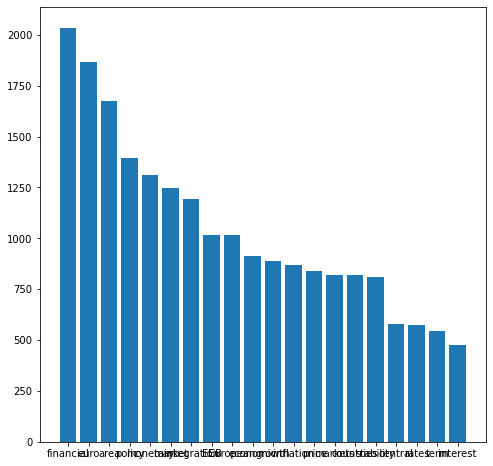

In [81]:
plt.clf()
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(x,y)

In [82]:
freq_words_year(df,2005,20)

[('financial', 2035),
 ('euro', 1865),
 ('area', 1676),
 ('policy', 1395),
 ('monetary', 1310),
 ('market', 1245),
 ('integration', 1191),
 ('ECB', 1016),
 ('European', 1015),
 ('economic', 911),
 ('growth', 887),
 ('inflation', 869),
 ('price', 840),
 ('markets', 819),
 ('countries', 819),
 ('stability', 811),
 ('central', 578),
 ('rates', 575),
 ('term', 543),
 ('interest', 477)]

In [83]:
# https://spacytextblob.netlify.app/docs/